# Roll decay test parameter sensitivity

None of the methods worked well unless the initial large roll angles were removed, probably beacause the nonlinearities are higher than quadratic for this case. Removing these angles (making the model valid for only smaller angles) is one option. Another option is to allow higher order damping terms in the simulation model for the fitting (the higher order terms can later be transfered to a model with linear och quadratic order at a later stage if required). How the cutting affects the parameter identification should be further investigated.

A sensitivity stuffy regarding the impact of lowpass filtering on the parameter identification should also be conducted. 


In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pylab import rcParams
rcParams['figure.figsize'] = 15, 7

import os
from scipy.optimize import curve_fit

from rolldecay.simulation import  simulate
from rolldecay.filtering import lowpass_filter
#import rolldecay.parameter_identification as parameter_identification
import rolldecay.read_funky_ascii
import inspect
from rolldecayestimators.direct_estimator import DirectEstimator
from rolldecay.equations_lambdify import calculate_acceleration, calculate_velocity

## Roll decay model test

In [35]:
ascii_path = os.path.join(rolldecay.data_path,'project1','Ascii files','20084871056k.15.asc')
df = rolldecay.read_funky_ascii.read(ascii_path=ascii_path)[['phi']]

In [36]:
scale = 29.565
df.index*=np.sqrt(scale)  # To full scale

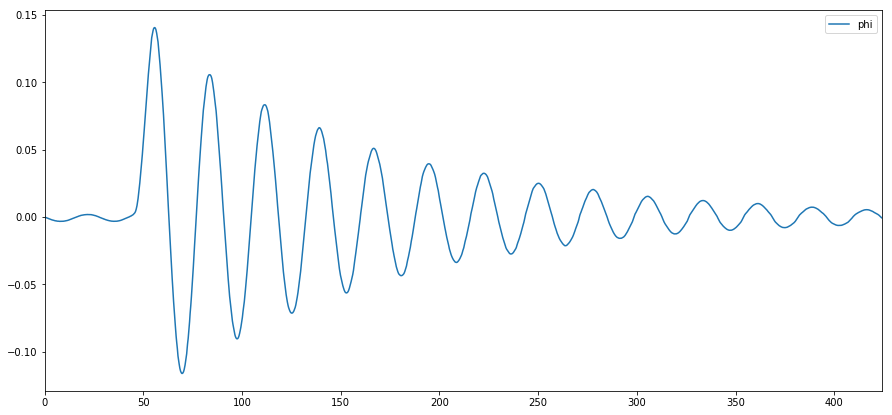

In [37]:
df.plot(y='phi')

### Cutting the file at max value 

In [38]:
index = df['phi'].abs().idxmax()
df_cut = df.loc[index:].copy()

In [39]:
df_cut['phi_raw'] = df_cut['phi']

### Low pass filtration of signal to remove measurement noice

In [83]:
ts = np.mean(np.diff(df_cut.index))
fs = 1/ts
df_cut['phi'] = lowpass_filter(data=df_cut['phi_raw'], cutoff=0.1, fs=fs, order=5)

c:\dev\rolldecay\venv\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


### Also cut the end of the signal

In [84]:
df_cut = df_cut.iloc[300:-300]

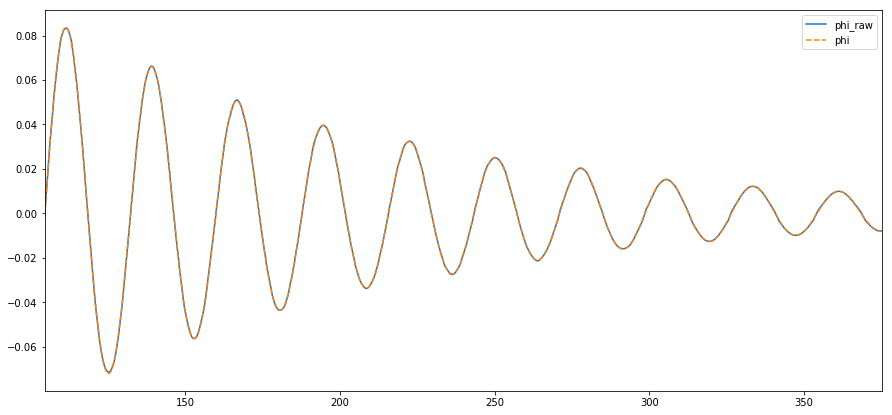

In [85]:
fig,ax=plt.subplots()
df_cut.plot(y='phi_raw', ax=ax)
df_cut.plot(y='phi', ax=ax, style='--')
ax.legend();

In [86]:
df_cut['phi1d'] = np.gradient(df_cut['phi'].values,df_cut.index.values)
df_cut['phi2d'] = np.gradient(df_cut['phi1d'].values,df_cut.index.values)

In [87]:
df_cut.isnull().any()

phi        False
phi_raw    False
phi1d      False
phi2d      False
dtype: bool

In [88]:
direct_estimator = DirectEstimator(calculate_acceleration=calculate_acceleration, simulate=simulate)
direct_estimator.fit(X=df_cut)

DirectEstimator(calculate_acceleration=<function _lambdifygenerated at 0x0EFF7E88>,
                p0=None, simulate=<function simulate at 0x10DA4858>)

In [89]:
direct_estimator.parameters

{'d': -0.24409591636483713,
 'omega0': 0.22675708053393825,
 'zeta': 0.04331295865632178}

In [90]:
direct_estimator.score(X=df_cut)

0.9988374485439163

In [78]:
df_sim_direct = direct_estimator.predict(X=df_cut)

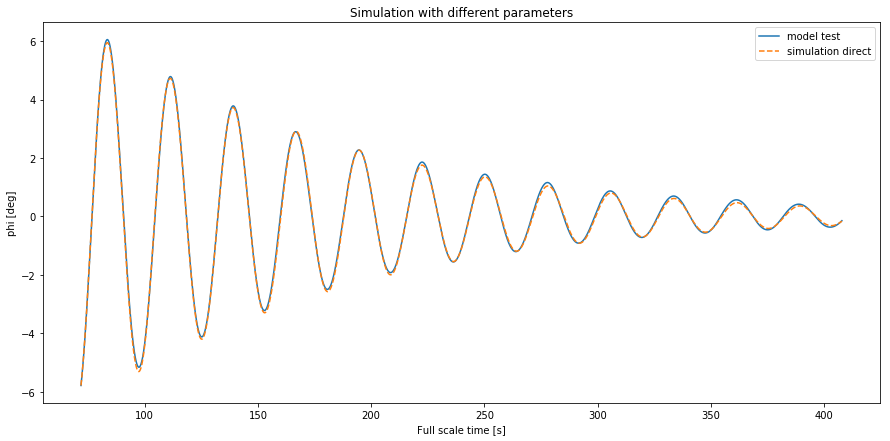

In [80]:
fig,ax = plt.subplots()

from collections import OrderedDict
dfs = OrderedDict()
dfs['model test']={'df':df_cut,'style':'-', 'alpha':1}
#dfs['simulation report']={'df':df_sim_report}
#dfs['simulation sim']={'df':df_sim}
dfs['simulation direct']={'df':df_sim_direct}

for label,data in dfs.items():
    df_ = data['df']
    style = data.get('style','--')
    alpha = data.get('alpha',1)
    ax.plot(df_.index,np.rad2deg(df_['phi']),style, label=label, alpha=alpha)

ax.legend()
ax.set_xlabel('Full scale time [s]')
ax.set_ylabel('phi [deg]')
ax.set_title('Simulation with different parameters');

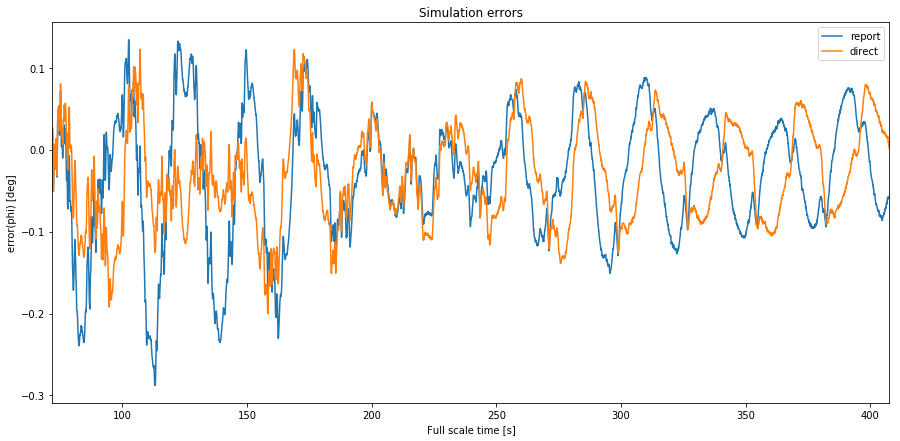

In [59]:
fig,ax = plt.subplots()
df_errors = pd.DataFrame(index=df_cut.index)
df_errors['report'] = df_sim_report['phi'] - df_cut['phi_raw']
#df_errors['sim'] = df_sim['phi'] - df_cut['phi_raw']
df_errors['direct'] = df_sim_direct['phi'] - df_cut['phi_raw']

df_errors_deg = np.rad2deg(df_errors)

df_errors_deg.plot(ax=ax)
ax.set_title('Simulation errors')
ax.set_xlabel('Full scale time [s]')
ax.set_ylabel('error(phi) [deg]');


In [60]:
def RMS_error(error_phi,phi_max):
    return (np.sqrt((error_phi/phi_max)**2)).mean()

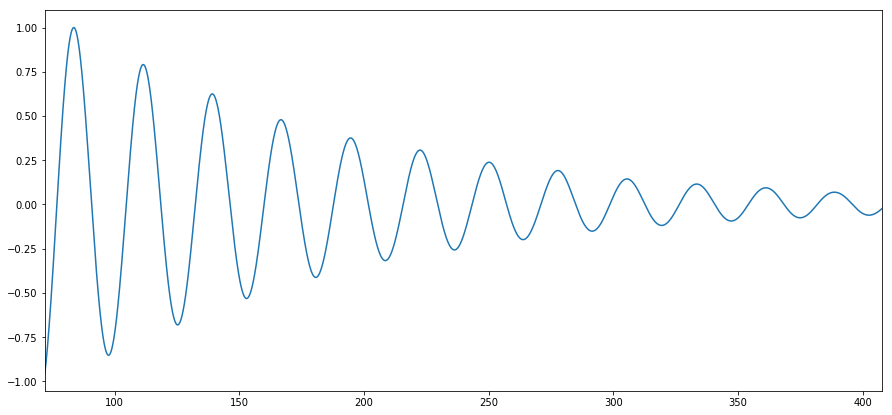

In [61]:
phi_max = df_cut['phi'].abs().max()
(df_cut['phi']/phi_max).plot()

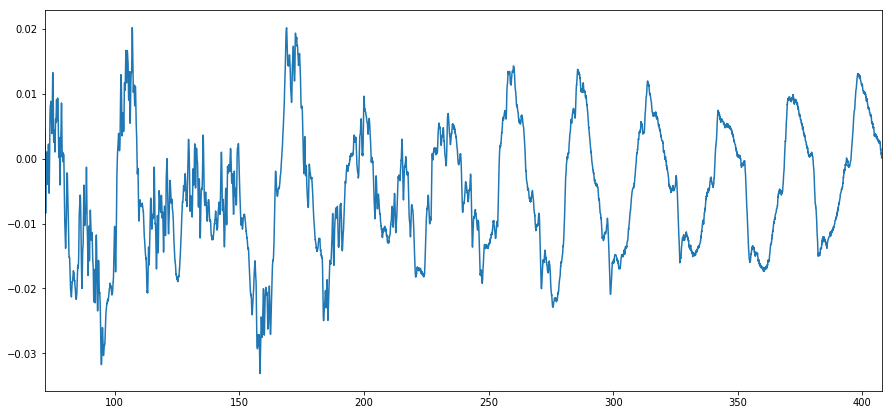

In [38]:
(df_errors['direct']/phi_max).plot()

Text(0.5, 1.0, "RMS error(phi'/max(phi))")

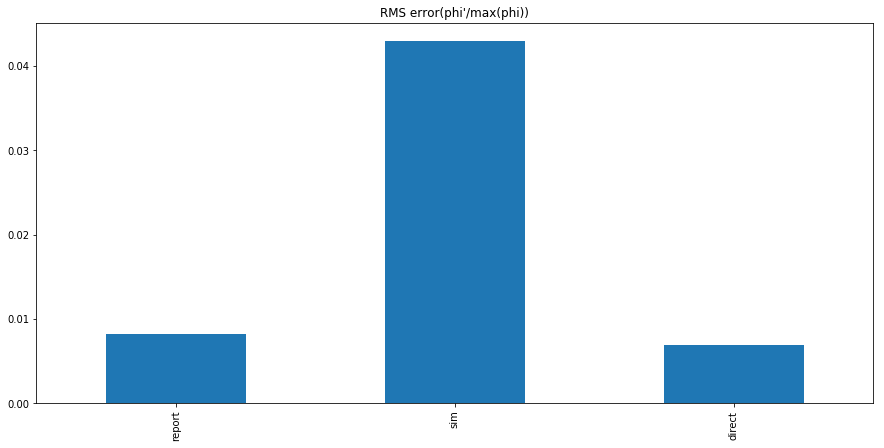

In [39]:
fig,ax = plt.subplots()
phi_max = df['phi'].abs().max()
s_RMS = df_errors.apply(func=RMS_error,phi_max=phi_max,axis=0)
s_RMS.plot(kind='bar');
ax.set_title("RMS error(phi'/max(phi))")

In [40]:

#def fit_optimize(df, p0=None):
#    
#    def error(x):
#    
#        omega0, d, zeta = x[0], x[1], x[2]
#    
#        phi_sim = f(df=df, omega0=omega0, d=d, zeta=zeta)
#        
#        phi = df['phi']
#        phi_max = phi.abs().max()
#        return (((phi_sim-phi)/phi_max)**2).mean()
#    
#    
#    if p0 is None:
#        p0 = [1,1,1]
#        
#    #return minimize(fun=error, x0=p0)
#    return basinhopping(func=error, x0=p0)
#    

In [41]:
#T0_guess = 27
#omega0_guess = 2*np.pi/T0_guess
#d_guess = 0.16  # Qudratic damping
#zeta_guess = 0.03  # Linear damping
#
#
#parameters = fit_optimize(df=df_cut, p0=[omega0_guess,d_guess,zeta_guess])

#parameters_optimize = {
#    'omega0':parameters.x[0],
#    'd':parameters.x[1],
#    'zeta':parameters.x[2],
#    
#}
#parameters_optimize

In [42]:
#df_sim2 = simulate(t=df_cut.index, **parameters_optimize, phi0=phi0, phi1d0=phi1d0)
#
#fig,ax = plt.subplots()
#df_cut.plot(y='phi', ax=ax, label='model test')
#df_sim2.plot(y='phi', ax=ax, label='simulation2')
#ax.set_title('Simulation with parameters from report')